In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#reference : https://towardsdatascience.com/predicting-ipl-match-winner-fc9e89f583ce

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-complete-dataset-20082020/IPL Matches 2008-2020.csv
/kaggle/input/ipl-complete-dataset-20082020/IPL Ball-by-Ball 2008-2020.csv


city                13
player_of_match      4
winner               4
result               4
result_margin       17
eliminator           4
method             797
dtype: int64
player_of_match      4
winner               4
result               4
result_margin       17
eliminator           4
method             797
dtype: int64
     team1  team2  team1_toss_win  team1_win  date  result_margin
0       12      7             1.0        0.0     0             88
1        5      0             0.0        0.0     0             32
2        3     10             0.0        1.0     0              8
3        8     12             1.0        0.0     0              4
4        7      1             0.0        1.0     0              4
..     ...    ...             ...        ...   ...            ...
811     12      8             0.0        1.0    12             91
812      8      2             0.0        1.0    12             53
813     12     13             0.0        0.0    12              5
814      2     

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


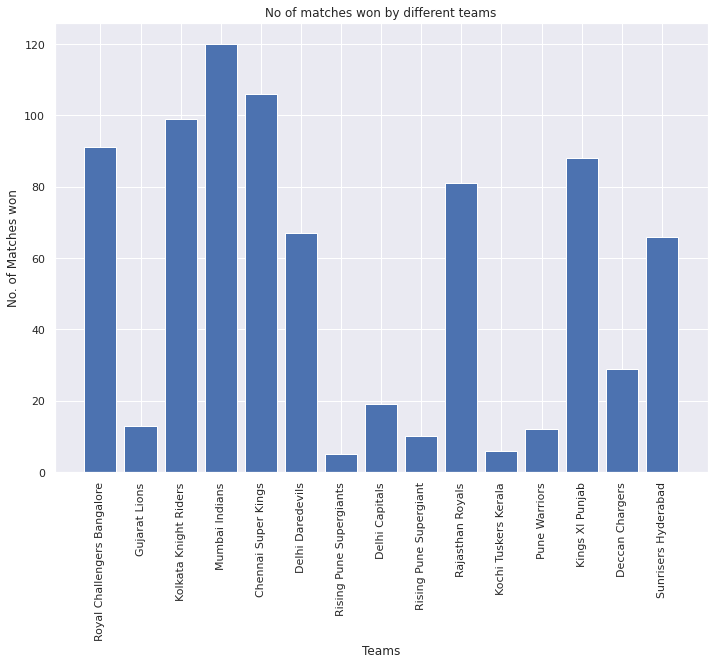

In [11]:

#Reading data from CSV file
matches=pd.read_csv("../input/ipl-complete-dataset-20082020/IPL Matches 2008-2020.csv")

#To check the number of columns containing null values
null_columns=matches.isnull().sum()
print(null_columns[null_columns > 0])

#imputing the values in column city based on venue
conditions = [matches["venue"] == "Rajiv Gandhi International Stadium, Uppal",matches["venue"] == "Maharashtra Cricket Association Stadium",
              matches["venue"] == "Saurashtra Cricket Association Stadium", matches["venue"] == "Holkar Cricket Stadium",
              matches["venue"] == "M Chinnaswamy Stadium",matches["venue"] == "Wankhede Stadium",
              matches["venue"] == "Eden Gardens",matches["venue"] == "Feroz Shah Kotla",
              matches["venue"] == "Punjab Cricket Association IS Bindra Stadium, Mohali",matches["venue"] == "Green Park",
              matches["venue"] == "Punjab Cricket Association Stadium, Mohali",matches["venue"] == "Dr DY Patil Sports Academy",
              matches["venue"] == "Sawai Mansingh Stadium", matches["venue"] == "MA Chidambaram Stadium, Chepauk", 
              matches["venue"] == "Newlands", matches["venue"] == "St George's Park" , 
              matches["venue"] == "Kingsmead", matches["venue"] == "SuperSport Park",
              matches["venue"] == "Buffalo Park", matches["venue"] == "New Wanderers Stadium",
              matches["venue"] == "De Beers Diamond Oval", matches["venue"] == "OUTsurance Oval", 
              matches["venue"] == "Brabourne Stadium",matches["venue"] == "Sardar Patel Stadium", 
              matches["venue"] == "Barabati Stadium", matches["venue"] == "Vidarbha Cricket Association Stadium, Jamtha",
              matches["venue"] == "Himachal Pradesh Cricket Association Stadium",matches["venue"] == "Nehru Stadium",
              matches["venue"] == "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",matches["venue"] == "Subrata Roy Sahara Stadium",
              matches["venue"] == "Shaheed Veer Narayan Singh International Stadium",matches["venue"] == "JSCA International Stadium Complex",
              matches["venue"] == "Sheikh Zayed Stadium",matches["venue"] == "Sharjah Cricket Stadium",
              matches["venue"] == "Dubai International Cricket Stadium",matches["venue"] == "M. A. Chidambaram Stadium",
              matches["venue"] == "Feroz Shah Kotla Ground",matches["venue"] == "M. Chinnaswamy Stadium",
              matches["venue"] == "Rajiv Gandhi Intl. Cricket Stadium" ,matches["venue"] == "IS Bindra Stadium",matches["venue"] == "ACA-VDCA Stadium"]
values = ['Hyderabad', 'Mumbai', 'Rajkot',"Indore","Bengaluru","Mumbai","Kolkata","Delhi","Mohali","Kanpur","Mohali","Pune","Jaipur","Chennai","Cape Town","Port Elizabeth","Durban",
          "Centurion",'Eastern Cape','Johannesburg','Northern Cape','Bloemfontein','Mumbai','Ahmedabad','Cuttack','Jamtha','Dharamshala','Chennai','Visakhapatnam','Pune','Raipur','Ranchi',
          'Abu Dhabi','Sharjah','Dubai','Chennai','Delhi','Bengaluru','Hyderabad','Mohali','Visakhapatnam']
matches['city'] = np.where(matches['city'].isnull(),
                              np.select(conditions, values),
                              matches['city'])
null_columns=matches.isnull().sum()
print(null_columns[null_columns > 0])

#Removing records having null values in "winner" column
matches=matches[matches["winner"].notna()]
matches

"""# Visualizations"""

#Toss affecting the win dataframe
toss_win_result = matches.groupby(['toss_winner']).winner.value_counts().reset_index(name="count")
toss_win_result['result']=np.where(toss_win_result.winner==toss_win_result.toss_winner,'won','lost')
toss_win_result_df = toss_win_result.groupby(['toss_winner','result'])['count'].sum().reset_index()


#Winning stats of teams bat/field first by venues 
venue_toss_decision_result=matches[["toss_winner","toss_decision","winner","venue"]]
venue_toss_decision_result["decision"]=np.where((venue_toss_decision_result.toss_winner == venue_toss_decision_result.winner) & (venue_toss_decision_result.toss_decision=="field"),"field_won","bat_won")
venue_result=venue_toss_decision_result.groupby(["venue"]).decision.value_counts().reset_index(name="count")

teams = list(set(matches.loc[:,'team1']))
matches_won = [len(matches.loc[matches['winner'] == i]) for i in teams]
plt.bar(np.arange(len(teams)), matches_won)
plt.xticks(np.arange(len(teams)), teams, rotation='vertical')
plt.ylabel('No. of Matches won')
plt.xlabel('Teams')
plt.title('No of matches won by different teams')

"""# Data Preprocessing & Prediction"""

#Replacing the Rising Pune Supergiant with Rising Pune Supergiants
matches["team2"]=matches["team2"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["team1"]=matches["team1"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["winner"]=matches["winner"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["toss_winner"]=matches["toss_winner"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["date"] = pd.DatetimeIndex(matches['date']).year

#encoder
encoder= LabelEncoder()
matches["team1"]=encoder.fit_transform(matches["team1"])
matches["team2"]=encoder.fit_transform(matches["team2"])
matches["winner"]=encoder.fit_transform(matches["winner"].astype(str))
matches["toss_winner"]=encoder.fit_transform(matches["toss_winner"])
matches["toss_decision"]=encoder.fit_transform(matches["toss_decision"])
matches["toss_winner"]=encoder.fit_transform(matches["toss_winner"])
matches["player_of_match"]=encoder.fit_transform(matches["player_of_match"])
matches["result_margin"]=encoder.fit_transform(matches["result_margin"])
matches["eliminator"]=encoder.fit_transform(matches["eliminator"])


matches["venue"]=encoder.fit_transform(matches["venue"])
matches["city"]=encoder.fit_transform(matches["city"])

matches["date"]=encoder.fit_transform(matches["date"])

#outcome variable as a probability of team1 winning
matches.loc[matches["winner"]==matches["team1"],"team1_win"]=1
matches.loc[matches["winner"]!=matches["team1"],"team1_win"]=0

matches.loc[matches["toss_winner"]==matches["team1"],"team1_toss_win"]=1
matches.loc[matches["toss_winner"]!=matches["team1"],"team1_toss_win"]=0



matches["team1_bat"]=0
matches.loc[(matches["team1_toss_win"]==1) & (matches["toss_decision"]=="bat"),"team1_bat"]=1



prediction_df=matches[["team1","team2","team1_toss_win","team1_win","date","result_margin"]]

print(prediction_df)

#dropping higly correlated features
correlated_features = set()
correlation_matrix = prediction_df.drop('team1_win', axis=1).corr()
correlation_matrix

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

prediction_df.drop(columns=correlated_features)

#feature selection
X = prediction_df.drop('team1_win', axis=1)
target = prediction_df['team1_win']
target=target.astype(int)



#Splitting the data into training and testing data and scaling it
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.05, random_state=0)
sc = StandardScaler()


X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [19]:
logreg = LogisticRegression(solver="liblinear")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# print(logreg.classes_, logreg.intercept_, logreg.coef_)

# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))


              precision    recall  f1-score   support

           0       0.67      0.27      0.38        15
           1       0.69      0.92      0.79        26

    accuracy                           0.68        41
   macro avg       0.68      0.59      0.58        41
weighted avg       0.68      0.68      0.64        41

Accuracy of logistic regression classifier on test set: 0.6829


In [13]:
cv = ShuffleSplit(n_splits=3, test_size=0.05, random_state=0)

scores = cross_val_score (logreg, X, target, cv=cv)

print(sum(scores)/len(scores))

0.6260162601626017
